In [9]:
### import packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import modelbase
from modelbase.ode import Model, LabelModel, LinearLabelModel, Simulator, mca

In [10]:
### parameter values as provided in the supplemental file by Liu et al (2020):
### note: to have all parameter values in lower case letters and to avoid mix-ups between 'k' and 'K', I renamed 
### parameters for threshold values from 'Kxx' to 'txx'. For example, the parameter the 'threshold of CLV3 
### activation' is termed 'Kcw' by Liu et al and got renamed here to 'tcw'.

param = [
    {'tcw': 0.2, 'ncw': 6, 'kcr':0.5, 'tcl':0.24, 'ncl':6, 'tch':0.13, 'nch':5, 'kcp':2.7, 
          'bcp':1, 'bcr':0.5, 'kwl':1, 'kwc':1, 'kwr':1.2, 'tww':0.53, 'nww':2, 'twl':0.29, 'nwl':6, 
          'twc':0.1, 'nwc':6, 'kwp':0.345, 'bwp':0.4, 'bwr':1, 'k0w':0.3, 'ac':0, 'thw':0.3, 'nhw':4, 
          'bhp':1, 'khp':1, 'bhw':1, 'khw':1, 'klp':10, 'blp':1.5, 'dwp':1, 'dcp':6, 'dlp':1.2}]

In [11]:
### compund starting values, all abbreviations for compounds start with capital letters:
### Liu et al state they used 0 for all six compounds within their model.
### Wr = WUSCHEL (WUS) encoding mRNA 
### Wp = WUSCHEL protein
### Cr = CLAVATA3 (CLV3) encoding mRNA
### Cp = CLAVATA3 peptide
### Ep = EPIDERMAL PATTERNING FACTOR LIKE (EPFL) peptides
### Hp = HAIRY MERISTEM1 (HAM1) protein

comp_t0 = [{"Wr":0, "Wp":0, "Cr":0, "Cp":0, "Ep":0, "Hp":0}]

In [12]:
### definition of the published ordinary differential euqtions by Liu et al in base python:

## function 1a, synthesis and degradation of WUSCHEL protein: 
def Wpsyn(Wr, kwp): # important: note all compounds within the equations first, then the parameters
    Wp = kwp * Wr
    return Wp
def Wpdeg(Wp, bwp):
    Wp = bwp * Wp
    return Wp

## function 1b, synthesis and degradation of CLAVATA3 peptide: 
def Cpsyn(Cr, kcp):
    Cp = kcp * Cr
    return Cp
def Cpdeg(Cp, bcp):
    Cp = bcp * Cp
    return Cp

## function 1c, synthesis and degradation of WUSCHEL encoding mRNA:
def Wrsyn(Ep, Cp, Wp, kwr, kwl, twl, nwl, kwc, twc, nwc, k0w, tww, nww):
    maxWrsyn = kwr
    EponWrsyn = kwl/(1+(Ep/twl)**nwl)
    CponWrsyn = kwc/(1+(Cp/twc)**nwc)
    k0w = k0w
    Wauto1 = (Wp/tww)**nww
    Wauto2 = 1 + (Wp/tww)**nww
    Wr = maxWrsyn * (EponWrsyn + CponWrsyn) * (k0w + (Wauto1/Wauto2))
    return Wr
def Wrdeg(Wr, bwr):
    Wr = bwr * Wr
    return Wr

# reaction 1d, synthesis and degradation of CLAVATA3 encoding mRNA:
def Crsyn(Ep, Wp, Hp, kcr, tcl, ncl, ac, tcw, ncw, tch, nch):
    maxCrsyn = kcr
    EponCrsyn = 1/(1 + (Ep/tcl) ** ncl)
    ac = ac
    WponCr1 = (Wp/tcw)**ncw
    WponCr2 = 1 + (Wp/tcw)**ncw
    HponCr = 1/(1 + (Hp/tch)**nch)
    Cr = maxCrsyn * EponCrsyn * (ac + WponCr1/WponCr2) * HponCr
    return Cr
def Crdeg(Cr, bcr):
    Cr = bcr * Cr
    return Cr
    
## function 1e, synthesis and degradation of EPIDERMAL PATTERNING FACTOR LIKE peptides:
def Epsyn(klp):
    Ep = klp * 1
    return Ep
def Epdeg(Ep, blp):
    Ep = blp * Ep
    return Ep

## function 1f, synthesis and degradation of HAIRY MERISTEM1 protein:
def Hpsyn(khp):
    Hp = khp * 1
    return Hp
def Hpdeg(Hp, bhp):
    Hp = bhp * Hp
    return Hp

In [13]:
### The model in modelbase:
### Each of the six compound is added into the model with two reactions, synthesis as well as degradation. 
### The overall scheme is identical for all compunds and extensively commented for the WUSCHEL protein. 

m = Model()
m.add_parameters(param[0])
m.add_compounds(["Wr", "Wp", "Cr", "Cp", "Ep", "Hp"])

# reaction 1a:
m.add_reaction(
    rate_name = 'WUS prot syn', # the new reaction has to have a unique name
    function = Wpsyn, # WUS protein synthesis is described by the Wpsyn function defined in base python above
    stoichiometry = {"Wp":1}, # the product of this function is one WUS protein (not two, etc) no compunds get used up in the reaction.
    dynamic_variables = ["Wr"], # compounds within Wpsyn that underlie a dynamic regulation
    parameters = ["kwp"], # all parameters of the Wpsyn function. Important: same order as in the definition of the Wpsyn function in base python.
    reversible = False) # in contrast to some biochemical reactions, protein synthesis is not a reversible process
m.add_reaction(
    rate_name= 'WUS prot deg', 
    function= Wpdeg, 
    stoichiometry= {"Wp": -1}, 
    dynamic_variables= ["Wp"], 
    parameters= ["bwp"], 
    reversible= False)

# reaction 1b:  
m.add_reaction(
    rate_name= 'CLV3 pep syn', 
    function = Cpsyn, 
    stoichiometry= {"Cp": 1}, 
    dynamic_variables= ["Cr"], 
    parameters= ["kcp"],
    reversible= False)
m.add_reaction(
    rate_name= 'CLV3 pep deg', 
    function= Cpdeg, 
    stoichiometry= {"Cp": -1}, 
    dynamic_variables= ["Cp"],
    parameters= ["bcp"], 
    reversible = False)

# reaction 1c: 
m.add_reaction(
    rate_name= 'WUS RNA syn',
    function= Wrsyn,
    stoichiometry= {"Wr": 1},
    dynamic_variables= ["Ep", "Cp", "Wp"],
    parameters= ["kwr", "kwl", "twl", "nwl", "kwc", "twc", "nwc", "k0w", "tww", "nww"], 
    reversible = False)
m.add_reaction(
    rate_name= 'WUS RNA deg',
    function= Wrdeg,
    stoichiometry= {"Wr": -1},
    dynamic_variables= ["Wr"] ,
    parameters= ["bwr"], 
    reversible = False)

# reaction 1d:
m.add_reaction(
    rate_name= 'CLV3 RNA syn',
    function= Crsyn,
    stoichiometry= {"Cr":1},
    dynamic_variables= ["Ep", "Wp", "Hp"],
    parameters= ["kcr", "tcl", "ncl", "ac", "tcw", "ncw", "tch", "nch"], 
    reversible = False)
m.add_reaction(
    rate_name= 'CLV3 RNA deg',
    function= Crdeg,
    stoichiometry= {"Cr": -1},
    dynamic_variables= ["Cr"],
    parameters= ["bcr"], 
    reversible = False)

# reaction 1e:
m.add_reaction(
    rate_name= 'EPFL prot syn',
    function= Epsyn,
    stoichiometry= {"Ep":1},
    dynamic_variables= [],
    parameters= ["klp"], 
    reversible = False)
m.add_reaction(
    rate_name= 'EPFL prot deg',
    function= Epdeg,
    stoichiometry= {"Ep":-1},
    dynamic_variables= ["Ep"],
    parameters= ["blp"], 
    reversible = False)

# reaction 1f:
m.add_reaction(
    rate_name= 'HAM prot syn',
    function= Hpsyn,
    stoichiometry= {"Hp": 1},
    dynamic_variables= [],
    parameters= ["khp"], 
    reversible = False)
m.add_reaction(
    rate_name= 'HAM prot deg',
    function= Hpdeg,
    stoichiometry= {"Hp":-1},
    dynamic_variables= ["Hp"],
    parameters= ["bhp"], 
    reversible = False)

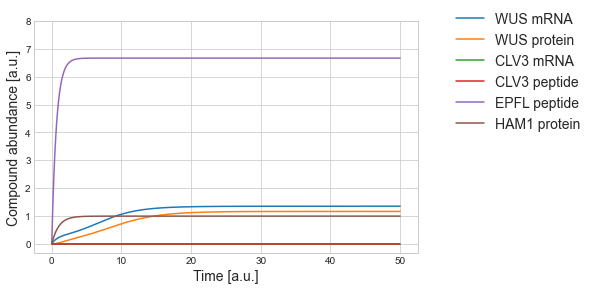

In [17]:
### simulate the model and plot compound abundances over time using matplotlib:

handles = ["WUS mRNA", "WUS protein", "CLV3 mRNA", "CLV3 peptide", "EPFL peptide", "HAM1 protein"]

s = Simulator(m) # simulate the model m
s.initialise(comp_t0[0]) # initialise model using the compound starting values defined above
t_m,res_m = s.simulate(50) # simulate until a timepoint 50 [a.u.]

fig, ax = plt.subplots()
ax.plot(t_m,res_m)
ax.set_ylim(top = 8)
ax.set_xlabel('Time [a.u.]', fontsize = 14) # include label 
ax.set_ylabel('Compound abundance [a.u.]', fontsize = 14) # include label
fig.legend(handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize= 14)
fig.tight_layout()
plt.style.use('seaborn-whitegrid')

# plt.savefig('all_compounds=0_givenpara_fin.pdf')
plt.show() # show plot